<a href="https://colab.research.google.com/github/RancyChepchirchir/hello-world/blob/master/cir_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
!pip install quandl
import quandl

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = quandl.get("FRED/DTB3", authtoken="mesng-xjfN_RUCyi_GJm")

In [0]:
df.shape

(16577, 1)

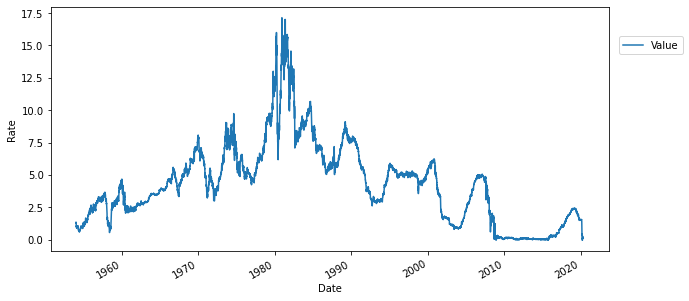

In [0]:
df.plot(figsize=(10,5))
plt.ylabel("Rate")
plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
plt.show()

As seen in the previous file (vasicek model), interest rates are mean reverting in nature. In this code, we will simulate out the rates using the CIR model, which unlike the Vasicek, takes into account the elasticity of the interest rate in the volatility term as in the equation below;

                dr(t)=κ (θ−rt) dt + σ \sqrt(rt) dW(t)

In [0]:
def CirNextRate(r, kappa, theta, sigma, dt=1/252):
    # Implements above closed form solution     
    val1 = np.exp(-1*kappa*dt)
    val2 = (sigma**2)*(1-val1**2) / (2*kappa)
    out = r*val1 + theta*(1-val1) + (np.sqrt(val2))*np.sqrt(r)*np.random.normal()
    return out

In [0]:
def CirSim(N, r0, kappa, theta, sigma, dt = 1/252):
    short_r = [0]*N # Create array to store rates   short_r[0] = r0 # Initialise rates at $r_0$     
    
    for i in range(1,N):
        short_r[i] = CirNextRate(short_r[i-1], kappa, theta, sigma, dt)
    
    return short_r

In [0]:
def CirMultiSim(M, N, r0, kappa, theta, sigma, dt = 1/252):
    sim_arr = np.ndarray((N, M))
    
    for i in range(0,M):
        sim_arr[:, i] = CirSim(N, r0, kappa, theta, sigma, dt)
    
    return sim_arr

In [0]:
def CirCalibration(df, dt=1/252):
    n = len(df)
    
    # Implement MLE to calibrate parameters  
    Sx = sum(df[0:(n-1)])
    Sy = sum(df[1:n])
    Sxx = np.dot(df[0:(n-1)], df[0:(n-1)])
    Sxy = np.dot(df[0:(n-1)], df[1:n])
    Syy = np.dot(df[1:n], df[1:n])
    
    theta = (Sy * Sxx - Sx * Sxy) / (n * (Sxx - Sxy) - (Sx**2 - Sx*Sy))
    kappa = -np.log((Sxy - theta * Sx - theta * Sy + n * theta**2) / (Sxx - 2*theta*Sx + n*theta**2)) / dt
    a = np.exp(-kappa * dt)
    sigmah2 = (Syy - 2*a*Sxy + a**2 * Sxx - 2*theta*(1-a)*(Sy - a*Sx) + n*theta**2 * (1-a)**2) / n
    sigma = np.sqrt(sigmah2*2*kappa / (1-a**2))
    r0 = df[n-1]
    
    return [kappa, theta, sigma, r0]

In [35]:
kappa, theta, sigma, r0

(1757.354187617423, 1.6270967672330174, 120.23112258960329, 8.290086284020596)

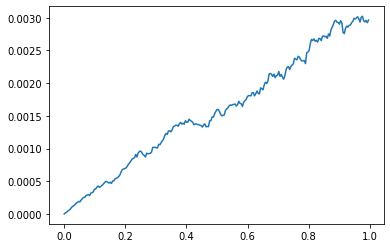

In [0]:
params = CirCalibration(df.Value.dropna()/100)
kappa = params[0]
theta = params[1]
sigma = params[2]
r0 = params[3]

years = 1
N = years * 252
t = np.arange(0,N)/252

test_sim = CirSim(N, r0, kappa, theta, sigma, 1/252)
plt.plot(t,test_sim)
plt.show()

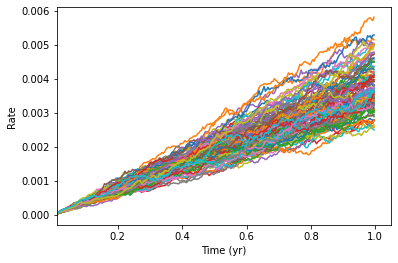

In [0]:
M = 100
rates_arr = CirMultiSim(M, N, r0, kappa, theta, sigma)

plt.plot(t,rates_arr)
plt.xlim(0.01, 1.05)
plt.ylabel("Rate")
plt.xlabel("Time (yr)")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


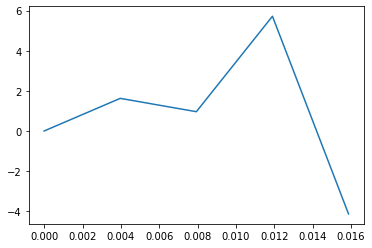

In [0]:
data = np.random.lognormal(size=16577)     #simulated series using the mle parameters
params = CirCalibration(data)
kappa = params[0]
theta = params[1]
sigma = params[2]
r0 = params[3]

years = 1
N = years * 252
t = np.arange(0,N)/252

test_sim = CirSim(N, r0, kappa, theta, sigma, 1/252)
plt.plot(t,test_sim)
plt.show()